[paper](https://www.nature.com/articles/s41746-020-00372-6.pdf)  
[dataset](https://github.com/nshomron/covidpred)

## 1. Data Preprocessing

In [480]:
# # 安裝會使用到的套件
# !pip install xgboost

In [481]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\Data_Mining\\project\\mid'

In [482]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import seaborn as sns
import time

In [483]:
metadata = pd.read_csv("covid.csv") #匯資料
metadata.head(3)

C:\Users\betty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


test_date cough fever sore_throat shortness_of_breath head_ache  \
0  2020-04-30     0     0           0                   0         0   
1  2020-04-30     1     0           0                   0         0   
2  2020-04-30     0     1           0                   0         0   

  corona_result age_60_and_above  gender test_indication  
0      negative             None  female           Other  
1      negative             None  female           Other  
2      negative             None    male           Other

In [484]:
# 增加id
metadata=metadata.assign(cov_id=metadata.index)

In [485]:
# 共有 278848 筆資料
metadata.shape

(278848, 11)

### 1.1. 方法一 : 去除空值

In [486]:
metadata['cough']=metadata['cough'].replace('None',np.nan)
metadata['fever']=metadata['fever'].replace('None',np.nan)
metadata['sore_throat']=metadata['sore_throat'].replace('None',np.nan)
metadata['shortness_of_breath']=metadata['shortness_of_breath'].replace('None',np.nan)
metadata['head_ache']=metadata['head_ache'].replace('None',np.nan)
metadata['gender']=metadata['gender'].replace(['female', 'male', 'None'], [0, 1, np.nan])
metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['None', 'No', 'Yes'], [np.nan, 0 ,1])
metadata['test_indication']=metadata['test_indication'].replace(['Contact with confirmed', 'Other', 'Abroad'], [1, 0,0])
# metadata['gender']=metadata['gender'].replace(['female', 'male'], [0,1])
# metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['No', 'Yes'], [0 ,1])
metadata

test_date cough fever sore_throat shortness_of_breath head_ache  \
0       2020-04-30     0     0           0                   0         0   
1       2020-04-30     1     0           0                   0         0   
2       2020-04-30     0     1           0                   0         0   
3       2020-04-30     1     0           0                   0         0   
4       2020-04-30     1     0           0                   0         0   
...            ...   ...   ...         ...                 ...       ...   
278843  2020-03-11     0     0           0                   0         0   
278844  2020-03-11     0     0           0                   0         0   
278845  2020-03-11     0     0           0                   0         0   
278846  2020-03-11     0     0           0                   0         0   
278847  2020-03-11     0     0           0                   0         0   

       corona_result  age_60_and_above  gender  test_indication  cov_id  
0           negative               NaN     0.0                0       0  
1           negative               NaN     0.0                0       1  
2           negative               NaN     1.0                0       2  
3           negative               NaN     0.0                0       3  
4           negative               NaN     1.0                0       4  
...              ...               ...     ...              ...     ...  
278843      negative               NaN     NaN                0  278843  
278844      negative               NaN     NaN                0  278844  
278845      positive               NaN     NaN                1  278845  
278846         other               NaN     NaN                0  278846  
278847      negative               NaN     NaN                0  278847  

[278848 rows x 11 columns]

In [487]:
# drop_na=metadata.dropna()
# print(metadata[metadata['cough']==np.nan].count())
# print(metadata[metadata['fever']==np.nan])
# print(metadata[metadata['sore_throat']==np.nan])
# print(metadata[metadata['shortness_of_breath']==np.nan])
# print(metadata[metadata['head_ache']==np.nan])
# print(metadata[metadata['age_60_and_above']==np.nan])
# print(metadata[metadata['gender']==np.nan])

metadata.isnull().sum()

test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
cov_id                      0
dtype: int64

age_60_and_above的空值將近50%，欄位值為 0 或 1，以 random 填空值

In [488]:
drop_na = metadata
drop_na.age_60_and_above.fillna(np.random.choice([0,1]), inplace =True)
# drop_na.age_60_and_above.fillna()
drop_na.isnull().sum()
# drop_na.shape

test_date                  0
cough                    252
fever                    252
sore_throat                1
shortness_of_breath        1
head_ache                  1
corona_result              0
age_60_and_above           0
gender                 19563
test_indication            0
cov_id                     0
dtype: int64

其他空值以前一個值填入

In [489]:
drop_na.cough.fillna(method='ffill', inplace=True)
drop_na.fever.fillna(method='ffill', inplace=True)
drop_na.sore_throat.fillna(method='ffill', inplace=True)
drop_na.shortness_of_breath.fillna(method='ffill', inplace=True)
drop_na.head_ache.fillna(method='ffill', inplace=True)
# drop_na.age_60_and_above.fillna(method='ffill', inplace=True)
drop_na.gender.fillna(method='ffill', inplace=True)
drop_na.test_indication.fillna(method='ffill', inplace=True)
drop_na.isnull().sum()


test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
cov_id                 0
dtype: int64

## 2. 將資料分為測試集和訓練集


### 2.1. 根據4:1的比例切分資料集 

利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 4:1，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

#### 2.1.1 all features

In [490]:
y= drop_na.corona_result

features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
X_all =drop_na[features_all]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.25, random_state=2022)

#### 2.1.2 filtered features

In [491]:
y= drop_na.corona_result

features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
X_filter =drop_na[features_filter]

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y, test_size=0.25, random_state=2022)

In [492]:
print(f"raw data percentage :\n{metadata['corona_result'].value_counts(normalize=True) * 100}")

raw data percentage :
negative    93.322168
positive     5.282089
other        1.395742
Name: corona_result, dtype: float64


In [493]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 2.2. Gradient Boosting

#### 2.2.1 Gradient Boosting (all)

In [494]:
model_type="Gradient Boosting (all)"
gb_all = GradientBoostingClassifier()
gb_all.fit(X_train_all, y_train_all)

GradientBoostingClassifier()

In [495]:
predicted_all = gb_all.predict(X_test_all)
predicted_prob_all = gb_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.95
Auc: 0.75
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.96      0.99      0.98     65054
       other       0.00      0.00      0.00       930
    positive       0.77      0.55      0.64      3728

    accuracy                           0.95     69712
   macro avg       0.58      0.51      0.54     69712
weighted avg       0.94      0.95      0.95     69712



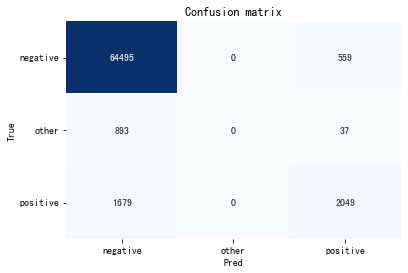

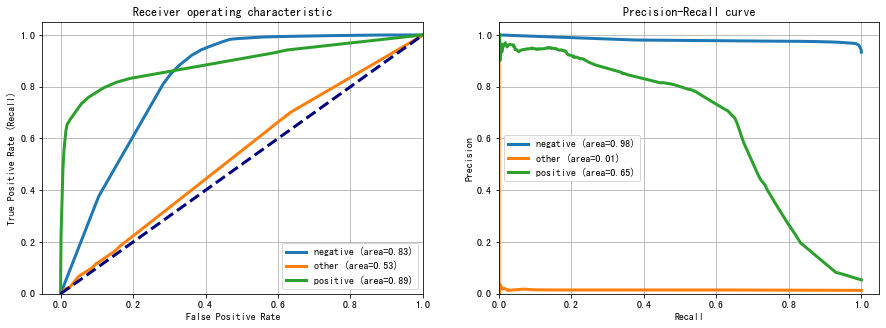

In [496]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.2.1 Gradient Boosting (filtered)

In [497]:
model_type="Gradient Boosting (filtered)"
gb_filter = GradientBoostingClassifier()
gb_filter.fit(X_train_filter, y_train_filter)

GradientBoostingClassifier()

In [498]:
predicted_filter = gb_filter.predict(X_test_filter)
predicted_prob_filter = gb_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.95
Auc: 0.74
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.96      0.99      0.97     65054
       other       0.00      0.00      0.00       930
    positive       0.72      0.46      0.56      3728

    accuracy                           0.95     69712
   macro avg       0.56      0.48      0.51     69712
weighted avg       0.93      0.95      0.94     69712



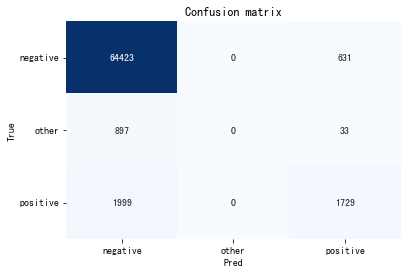

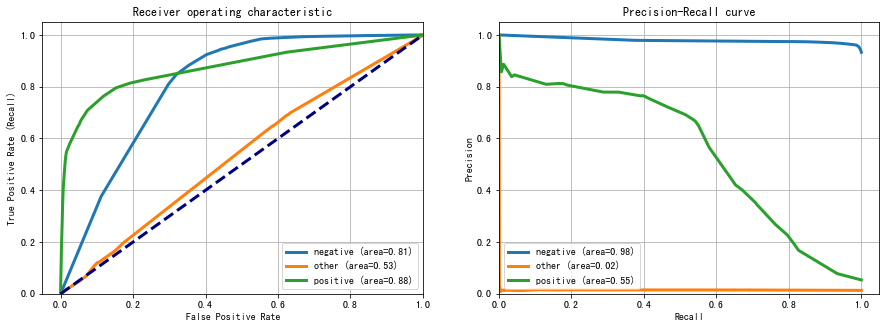

In [499]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.3. Decision Tree

#### 2.3.1 Decision Tree (all)

In [500]:
dt_all = DecisionTreeClassifier()
dt_all.fit(X_train_all, y_train_all)

DecisionTreeClassifier()

In [501]:
model_type="Decision Tree (all)"
predicted_all = dt_all.predict(X_test_all)
predicted_prob_all = dt_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [502]:
class_name=['negative', 'positive', 'other']
fig=plt.figure(figsize=(500, 50))
plot_tree(dt_all, 
          feature_names=features_all,
          class_names=class_name,
          fontsize=20,
          filled=True)

[Text(15388.84573699422, 2567.0, 'test_indication <= 0.5\ngini = 0.126\nsamples = 209136\nvalue = [195173, 2962, 11001]\nclass = negative'),
 Text(8728.829479768787, 2265.0, 'head_ache <= 0.5\ngini = 0.081\nsamples = 201192\nvalue = [192795, 2838, 5559]\nclass = negative'),
 Text(4797.832369942196, 1963.0, 'sore_throat <= 0.5\ngini = 0.073\nsamples = 200285\nvalue = [192732, 2827, 4726]\nclass = negative'),
 Text(2580.3468208092486, 1661.0, 'shortness_of_breath <= 0.5\ngini = 0.07\nsamples = 199748\nvalue = [192551, 2817, 4380]\nclass = negative'),
 Text(1290.1734104046243, 1359.0, 'fever <= 0.5\ngini = 0.067\nsamples = 199251\nvalue = [192355, 2810, 4086]\nclass = negative'),
 Text(645.0867052023121, 1057.0, 'cough <= 0.5\ngini = 0.056\nsamples = 186431\nvalue = [181132, 2596, 2703]\nclass = negative'),
 Text(322.5433526011561, 755.0, 'gender <= 0.5\ngini = 0.05\nsamples = 169161\nvalue = [164844, 2331, 1986]\nclass = negative'),
 Text(161.27167630057804, 453.0, 'age_60_and_above <= 0

In [503]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_all, X_test_all, y_train_all, y_test_all)

max_leaf = 2, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 2, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 2, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 4, min_samples = 20, accuracy = 0.9530783796190039
max_leaf = 4, min_samples = 30, accuracy = 0.9530783796190039
max_leaf = 4, min_samples = 40, accuracy = 0.9530783796190039
max_leaf = 5, min_samples = 20, accuracy = 0.9534513426669727
max_leaf = 5, min_samples = 30, accuracy = 0.9534513426669727
max_leaf = 5, min_samples = 40, accuracy = 0.9534513426669727
max_leaf = 6, min_samples = 20, accuracy = 0.9534513426669727
max_leaf = 6, min_samples = 30, accuracy = 0.9534513426669727
max_leaf = 6, min_samples = 40, accuracy = 0.9534513426669727
max_leaf = 8, min_samples = 20, accuracy = 0.9534513426669727
max_leaf = 8, min_samples = 30, accuracy = 0.9534513426669727
max_leaf = 8, min_samples = 40, accuracy = 0.9534513426669727
max_leaf = 10, min_samples = 20, accuracy = 0.9535947899931145
max_lea

Accuracy: 0.95
Auc: 0.75
Detail:
              precision    recall  f1-score   support

    negative       0.96      0.99      0.98     65054
       other       0.00      0.00      0.00       930
    positive       0.78      0.55      0.64      3728

    accuracy                           0.95     69712
   macro avg       0.58      0.51      0.54     69712
weighted avg       0.94      0.95      0.95     69712



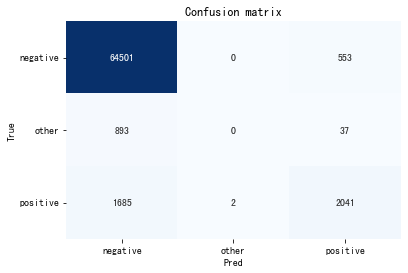

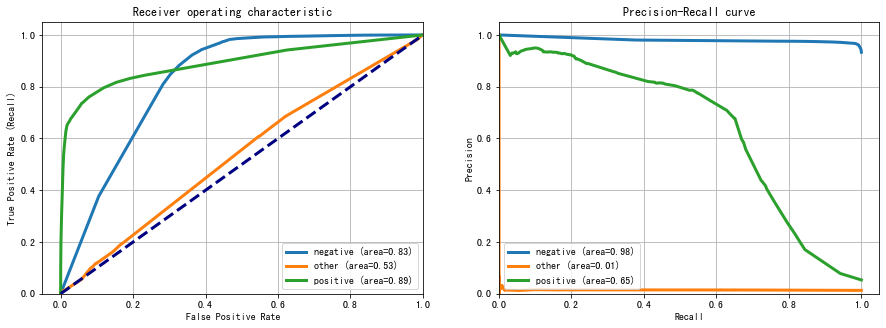

In [504]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.3.2 Decision Tree (filtered)

In [505]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 3, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_filter, X_test_filter, y_train_filter, y_test_filter)

max_leaf = 2, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 2, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 2, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 3, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 3, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 3, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 4, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 4, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 4, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 5, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 5, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 5, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 6, min_samples = 20, accuracy = 0.9488753729630479
max_leaf = 6, min_samples = 30, accuracy = 0.9488753729630479
max_leaf = 6, min_samples = 40, accuracy = 0.9488753729630479
max_leaf = 8, min_samples = 20, accuracy = 0.9488753729630479
max_leaf

In [506]:
dt_filter = DecisionTreeClassifier(max_leaf_nodes=16)
dt_filter.fit(X_train_filter, y_train_filter)

DecisionTreeClassifier(max_leaf_nodes=16)

In [507]:
model_type="Decision Tree (filterd)"
predicted_filter = dt_filter.predict(X_test_filter)
predicted_prob_filter = dt_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

[Text(7323.75, 2491.5, 'test_indication <= 0.5\ngini = 0.126\nsamples = 209136\nvalue = [195173, 2962, 11001]\nclass = negative'),
 Text(3487.5, 2038.5, 'fever <= 0.5\ngini = 0.081\nsamples = 201192\nvalue = [192795, 2838, 5559]\nclass = negative'),
 Text(1116.0, 1585.5, 'cough <= 0.5\ngini = 0.062\nsamples = 187348\nvalue = [181437, 2606, 3305]\nclass = negative'),
 Text(558.0, 1132.5, 'gini = 0.053\nsamples = 169578\nvalue = [164972, 2335, 2271]\nclass = negative'),
 Text(1674.0, 1132.5, 'age_60_and_above <= 0.5\ngini = 0.138\nsamples = 17770\nvalue = [16465, 271, 1034]\nclass = negative'),
 Text(1116.0, 679.5, 'gini = 0.129\nsamples = 16381\nvalue = [15260, 247, 874]\nclass = negative'),
 Text(2232.0, 679.5, 'gini = 0.234\nsamples = 1389\nvalue = [1205, 24, 160]\nclass = negative'),
 Text(5859.0, 1585.5, 'age_60_and_above <= 0.5\ngini = 0.3\nsamples = 13844\nvalue = [11358, 232, 2254]\nclass = negative'),
 Text(3906.0, 1132.5, 'gender <= 0.5\ngini = 0.263\nsamples = 12399\nvalue = [

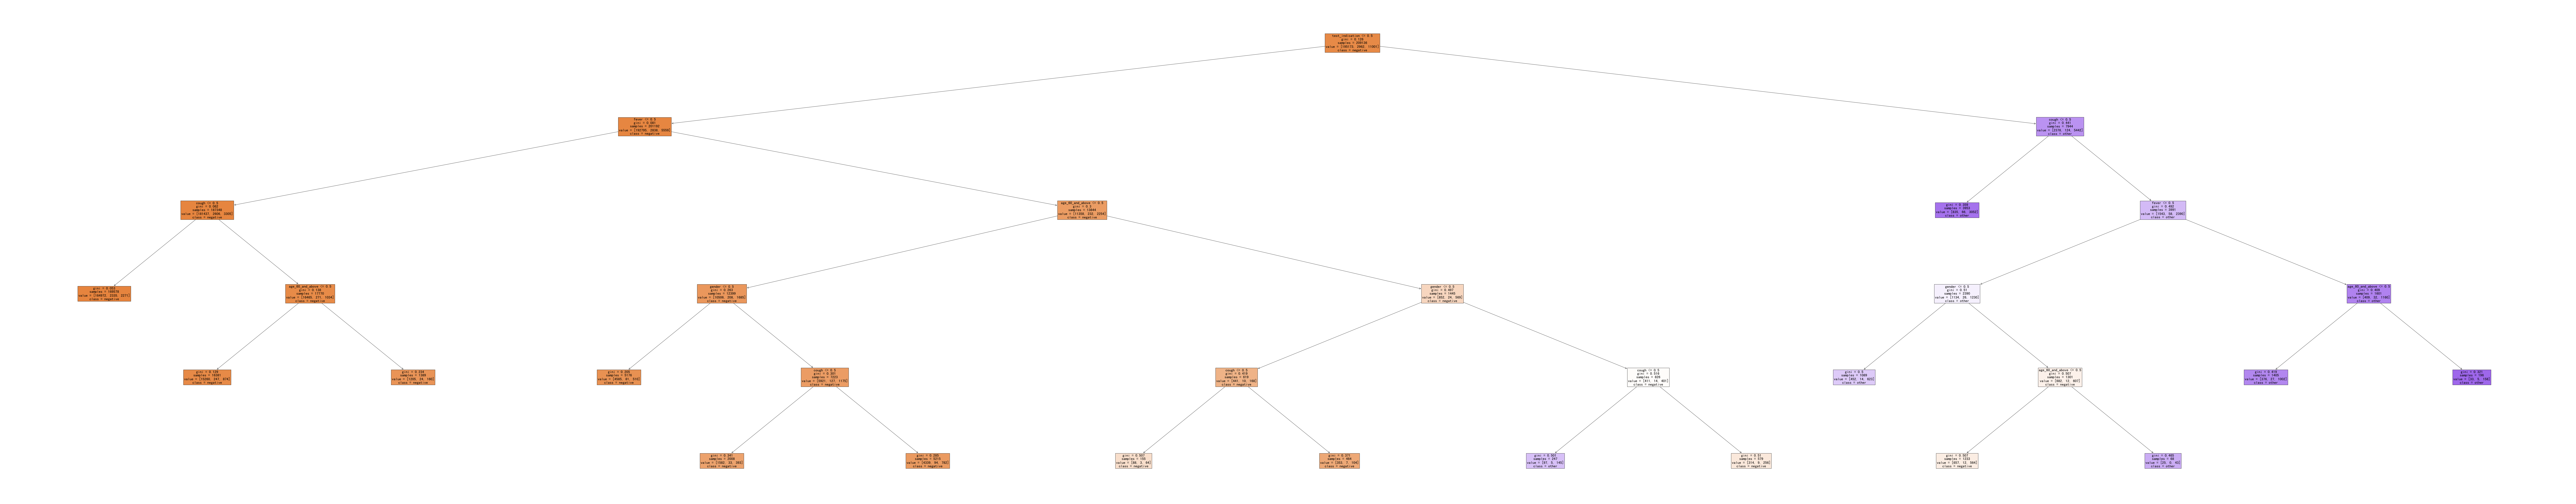

In [508]:
class_name=['negative', 'positive', 'other']
fig=plt.figure(figsize=(250, 50))
plot_tree(dt_filter, 
          feature_names=features_filter,
          class_names=class_name,
          fontsize=20,
          filled=True)

Accuracy: 0.95
Auc: 0.73
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.96      0.99      0.97     65054
       other       0.00      0.00      0.00       930
    positive       0.72      0.46      0.56      3728

    accuracy                           0.95     69712
   macro avg       0.56      0.48      0.51     69712
weighted avg       0.93      0.95      0.94     69712



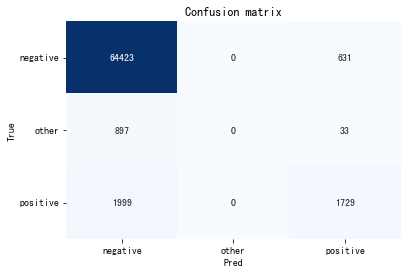

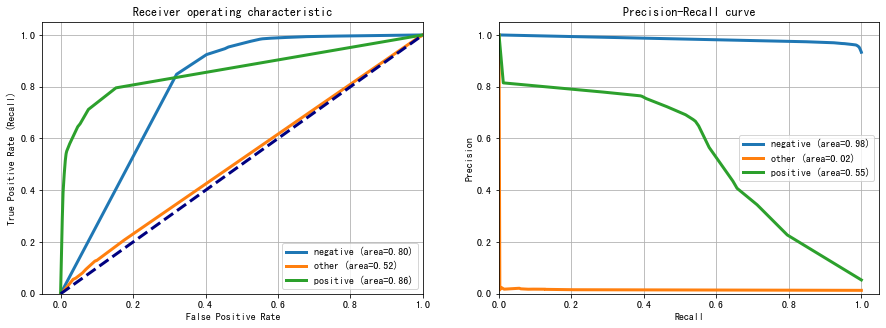

In [509]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.4. Random Forest

#### 2.4.1 Random Forest (all)

In [510]:
rf_all = ensemble.RandomForestClassifier()
rf_all.fit(X_train_all, y_train_all)

RandomForestClassifier()

In [511]:
model_type="Random Forest (all)"
predicted_all = rf_all.predict(X_test_all)
predicted_prob_all = rf_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.95
Auc: 0.75
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.96      0.99      0.98     65054
       other       0.00      0.00      0.00       930
    positive       0.78      0.55      0.64      3728

    accuracy                           0.95     69712
   macro avg       0.58      0.51      0.54     69712
weighted avg       0.94      0.95      0.95     69712



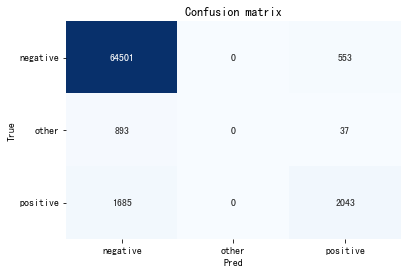

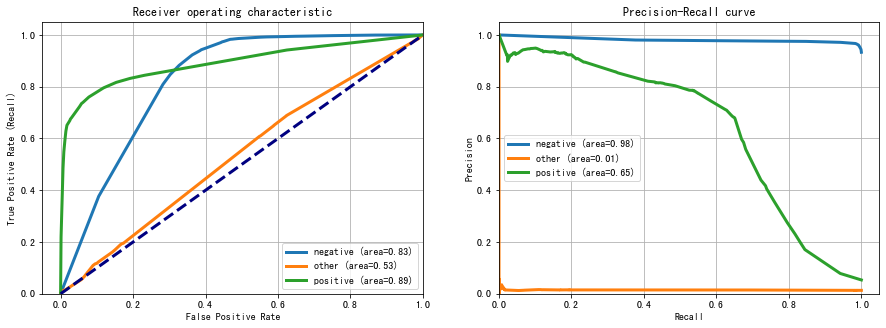

In [512]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.4.2 Random Forest (filtered)

In [513]:
rf_filter = ensemble.RandomForestClassifier()
rf_filter.fit(X_train_filter, y_train_filter)

RandomForestClassifier()

In [514]:
model_type="Random Forest (filered)"
predicted_filter = rf_filter.predict(X_test_filter)
predicted_prob_filter = rf_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.95
Auc: 0.74
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.96      0.99      0.97     65054
       other       0.00      0.00      0.00       930
    positive       0.72      0.46      0.56      3728

    accuracy                           0.95     69712
   macro avg       0.56      0.48      0.51     69712
weighted avg       0.93      0.95      0.94     69712



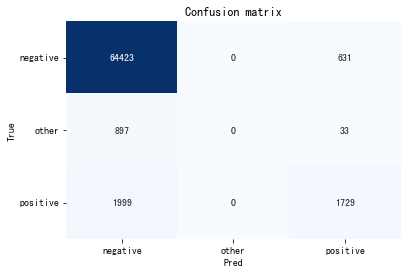

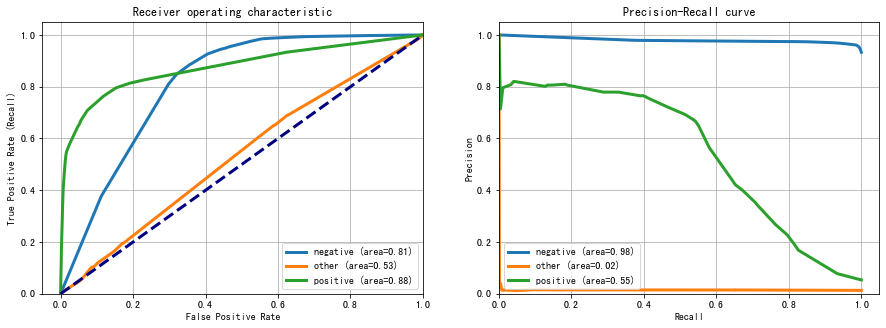

In [515]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.5. AdaBoost

In [516]:
# xgb = XGBClassifier(learning_rate=0.01,
#                       n_estimators=20,           # 树的个数-10棵树建立xgboost
#                       max_depth=10,               # 树的深度
#                       min_child_weight = 1,      # 叶子节点最小权重
#                       gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                       subsample=1,               # 所有样本建立决策树
#                       colsample_btree=1,         # 所有特征建立决策树
#                       scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                       random_state=42,           # 随机数
#                       slient = 0
#                       )
# xgb.fit(X_train_all,y_train_all)

#### 2.5.1 AdaBoost (all)

In [517]:
ada_all = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

ada_all.fit(X_train_all, y_train_all)

AdaBoostClassifier(learning_rate=0.02, random_state=42)

In [518]:
model_type="AdaBoost (all)"
predicted_all = ada_all.predict(X_test_all)
predicted_prob_all = ada_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.94
Auc: 0.71
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.94      1.00      0.97     65054
       other       0.00      0.00      0.00       930
    positive       0.79      0.23      0.35      3728

    accuracy                           0.94     69712
   macro avg       0.58      0.41      0.44     69712
weighted avg       0.92      0.94      0.92     69712



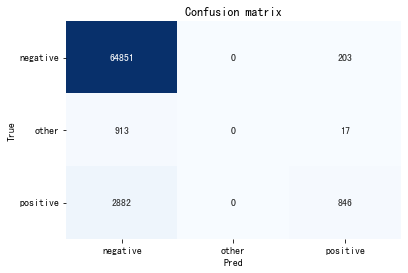

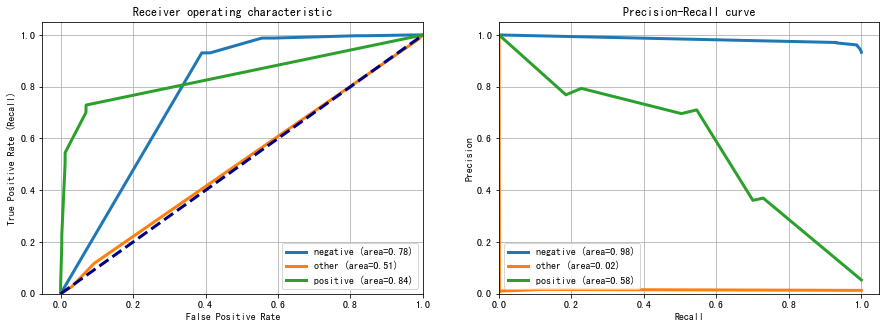

In [519]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.5.2 AdaBoost (filtered)

In [520]:
ada_filter = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

ada_filter.fit(X_train_filter, y_train_filter)

AdaBoostClassifier(learning_rate=0.02, random_state=42)

In [521]:
model_type="AdaBoost (filered)"
predicted_filter = ada_filter.predict(X_test_filter)
predicted_prob_filter = ada_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.94
Auc: 0.7
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.94      1.00      0.97     65054
       other       0.00      0.00      0.00       930
    positive       0.77      0.18      0.30      3728

    accuracy                           0.94     69712
   macro avg       0.57      0.39      0.42     69712
weighted avg       0.92      0.94      0.92     69712



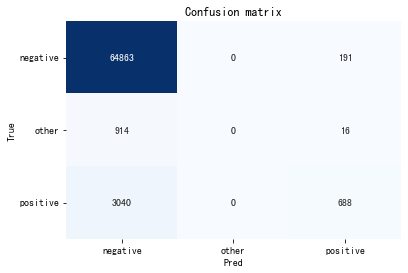

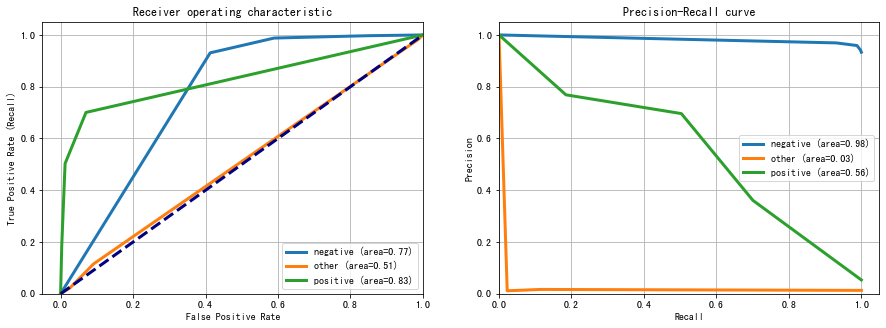

In [522]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.6. 比較

In [523]:
result_df.sort_values(by=['Accuracy'], ascending=False)

model_type  Accuracy       AUC  F1-score
0       Gradient Boosting (all)  0.954556  0.750260  0.945455
4           Random Forest (all)  0.954556  0.750106  0.945421
2           Decision Tree (all)  0.954527  0.750333  0.945398
1  Gradient Boosting (filtered)  0.948933  0.740413  0.938530
3       Decision Tree (filterd)  0.948933  0.726094  0.938530
5       Random Forest (filered)  0.948933  0.739827  0.938530
6                AdaBoost (all)  0.942406  0.711717  0.924152
7            AdaBoost (filered)  0.940312  0.702824  0.920206

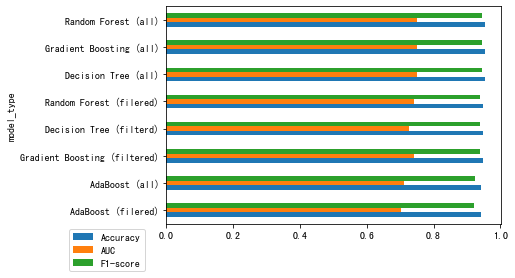

In [524]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC", "F1-score"])
plt.legend(bbox_to_anchor=(-0.05,0))